In [2]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense,GlobalAvgPool2D,Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint,ReduceLROnPlateau
import string
import numpy as np
import os
from plot_model import plot_model

In [3]:
# 字符包含所有数字和所有小写英文字母，一共62个
characters = string.digits + string.ascii_letters
# 类别数62
num_classes = len(characters)
# 批次大小
batch_size = 64
# 周期数
epochs=100
# 训练集数据，大约50000张图片
# 事先用captcha模块生成，长度都是4
train_dir = "./captcha/train/"
# 测试集数据，大约10000张图片
# 事先用captcha模块生成，长度都是4
test_dir = "./captcha/test/"
# 图片宽度
width=160
# 图片高度
height=60

In [4]:
# 获取所有验证码图片路径和标签
def get_filenames_and_classes(dataset_dir):
    # 存放图片路径
    photo_filenames = []
    # 存放图片标签
    y = []
    for filename in os.listdir(dataset_dir):
        # 获取文件完整路径
        path = os.path.join(dataset_dir, filename)
        # 保存图片路径
        photo_filenames.append(path)
        # 取文件名前4位，也就是验证码的标签
        captcha_text = filename[0:4]
        # 定义一个空label
        label = np.zeros((4, num_classes), dtype=np.uint8)
        # 标签转独热编码
        for i, ch in enumerate(captcha_text):
            # 设置标签，独热编码one-hot格式
            # characters.find(ch)得到ch在characters中的位置，可以理解为ch的编号
            label[i, characters.find(ch)] = 1
        # 保存独热编码的标签
        y.append(label)
    # 返回图片路径和标签
    return np.array(photo_filenames),np.array(y)

In [5]:
# 获取训练集图片路径和标签
x_train,y_train = get_filenames_and_classes(train_dir)

# 获取测试集图片路径和标签
x_test,y_test = get_filenames_and_classes(test_dir)

In [6]:
# 图像处理函数
# 获得每一条数据的图片路径和标签
def image_function(filenames, label):
    # 根据图片路径读取图片内容
    image = tf.io.read_file(filenames)
    # 将图像解码为jpeg格式的3维数据
    image = tf.image.decode_jpeg(image, channels=3)   
    # 归一化
    image = tf.cast(image, tf.float32) / 255.0
    # 返回图片数据和标签
    return image, label

In [7]:
# 标签处理函数
# 获得每一个批次的图片数据和标签
def label_function(image, label):
    # transpose改变数据的维度，比如原来的数据shape是(64,4,62)
    # 这里的64是批次大小，验证码长度为4有4个标签，62是62个不同的字符
    # tf.transpose(label,[1,0,2])计算后得到的shape为(4,64,62)
    # 原来的第1个维度变成了第0维度，原来的第0维度变成了1维度，第2维不变
    # (64,4,62)->(4,64,62)
    label = tf.transpose(label,[1,0,2])
    # 返回图片内容和标签，注意这里标签的返回，我们的模型会定义4个任务，所以这里返回4个标签
    # 每个标签的shape为(64,62)，64是批次大小，62是独热编码格式的标签
    return image, (label[0],label[1],label[2],label[3])

In [8]:
# 创建dataset对象，传入训练集图片路径和标签
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# 打乱数据，buffer_size定义数据缓冲器大小，随意设置一个较大的值
# reshuffle_each_iteration=True，每次迭代都会随机打乱
dataset_train = dataset_train.shuffle(buffer_size=1000,reshuffle_each_iteration=True)
# map-可以自定义一个函数来处理每一条数据
dataset_train = dataset_train.map(image_function)
# 数据重复生成1个周期
dataset_train = dataset_train.repeat(1)
# 定义批次大小
dataset_train = dataset_train.batch(batch_size)
# 注意这个map和前面的map有所不同，第一个map在batch之前，所以是处理每一条数据
# 这个map在batch之后，所以是处理每一个batch的数据
dataset_train = dataset_train.map(label_function)

# 创建dataset对象，传入测试集图片路径和标签
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# 打乱数据，buffer_size定义数据缓冲器大小，随意设置一个较大的值
# reshuffle_each_iteration=True，每次迭代都会随机打乱
dataset_test = dataset_test.shuffle(buffer_size=1000,reshuffle_each_iteration=True)
# map-可以自定义一个函数来处理每一条数据
dataset_test = dataset_test.map(image_function)
# 数据重复生成1个周期
dataset_test = dataset_test.repeat(1)
# 定义批次大小
dataset_test = dataset_test.batch(batch_size)
# 注意这个map和前面的map有所不同，第一个map在batch之前，所以是处理每一条数据
# 这个map在batch之后，所以是处理每一个batch的数据
dataset_test = dataset_test.map(label_function)

In [13]:
# 生成一个批次的数据和标签
# 可以用于查看数据和标签的情况
x,y = next(iter(dataset_test))
print(x.shape)
print(np.array(y).shape)

(64, 60, 160, 3)
(4, 64, 62)


In [10]:
# 也可以使用循环迭代的方式循环一个周期的数据，每次循环获得一个批次
# for x,y in dataset_test:
#     pass

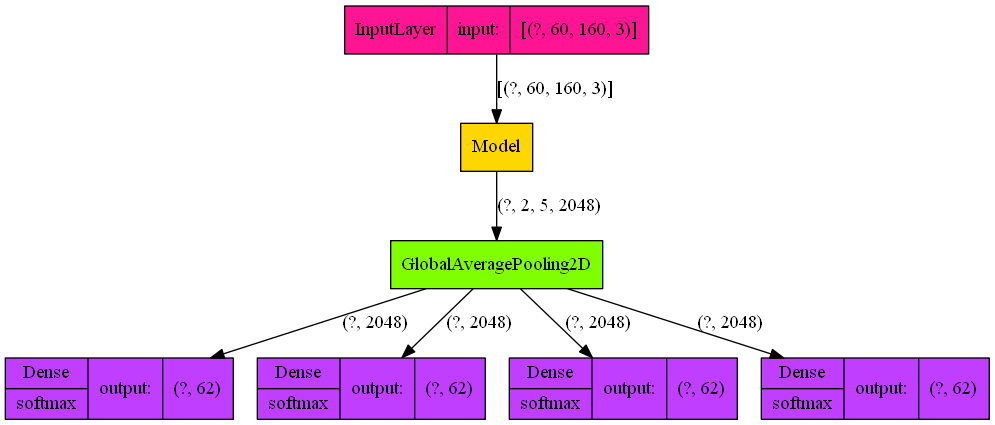

In [11]:
# 载入预训练的resnet50模型
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(height,width,3))
# 设置输入
inputs = Input((height,width,3))
# 使用resnet50进行特征提取
x = resnet50(inputs)
# 平均池化
x = GlobalAvgPool2D()(x)
# 把验证码识别的4个字符看成是4个不同的任务
# 每个任务负责识别1个字符
# 任务1识别第1个字符，任务2识别第2个字符，任务3识别第3个字符，任务4识别第4个字符
x0 = Dense(num_classes, activation='softmax', name='out0')(x)
x1 = Dense(num_classes, activation='softmax', name='out1')(x)
x2 = Dense(num_classes, activation='softmax', name='out2')(x)
x3 = Dense(num_classes, activation='softmax', name='out3')(x)
# 定义模型
model = Model(inputs, [x0,x1,x2,x3])
# 画图
plot_model(model,style=0)

In [12]:
# 4个任务我们可以定义4个loss
# loss_weights可以用来设置不同任务的权重，验证码识别的4个任务权重都一样
model.compile(loss={'out0':'categorical_crossentropy',
                    'out1':'categorical_crossentropy',
                    'out2':'categorical_crossentropy',
                    'out3':'categorical_crossentropy'},
              loss_weights={'out0':1,
                            'out1':1,
                            'out2':1,
                            'out3':1},
              optimizer=SGD(lr=1e-2,momentum=0.9),
              metrics=['acc'])

# 监控指标统一使用val_loss
# 可以使用EarlyStopping来让模型停止，连续6个周期val_loss没有下降就结束训练
# CSVLogger保存训练数据
# ModelCheckpoint保存所有训练周期中val_loss最低的模型
# ReduceLROnPlateau学习率调整策略，连续3个周期val_loss没有下降当前学习率乘以0.1
callbacks = [EarlyStopping(monitor='val_loss', patience=6, verbose=1),
             CSVLogger('Captcha_tfdata.csv'), 
             ModelCheckpoint('Best_Captcha_tfdata.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

In [13]:
# 训练模型
# 把之前定义的dataset_train和dataset_test传入进行训练
model.fit(x=dataset_train,
          epochs=epochs,
          validation_data=dataset_test,
          callbacks=callbacks)

Train for 781 steps, validate for 156 steps
Epoch 1/100
781/781 [==============================] - 96s 123ms/step - loss: 7.1427 - out0_loss: 1.3058 - out1_loss: 2.1121 - out2_loss: 2.0675 - out3_loss: 1.6573 - out0_acc: 0.6824 - out1_acc: 0.4488 - out2_acc: 0.4548 - out3_acc: 0.5494 - val_loss: 16.5515 - val_out0_loss: 9.0025 - val_out1_loss: 3.4140 - val_out2_loss: 2.1353 - val_out3_loss: 1.9997 - val_out0_acc: 0.0323 - val_out1_acc: 0.2611 - val_out2_acc: 0.4728 - val_out3_acc: 0.4884
Epoch 2/100
781/781 [==============================] - 88s 113ms/step - loss: 1.7508 - out0_loss: 0.7424 - out1_loss: 0.3910 - out2_loss: 0.3525 - out3_loss: 0.2649 - out0_acc: 0.8490 - out1_acc: 0.8838 - out2_acc: 0.8934 - out3_acc: 0.9171 - val_loss: 9.0221 - val_out0_loss: 7.7934 - val_out1_loss: 0.4909 - val_out2_loss: 0.4041 - val_out3_loss: 0.3337 - val_out0_acc: 0.1984 - val_out1_acc: 0.8448 - val_out2_acc: 0.8715 - val_out3_acc: 0.8904
Epoch 3/100
781/781 [==============================] - 88s 